In [133]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm

In [137]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
psep = 5.50410 # proton separation energy of 22Mg
psep_err = 0.00016 # error of proton separation energy of 22Mg
bw = 0.01 # bin width to be used, 10 keV
scale = 3.326542500626603 # difference in solid angle coverage of two proton events up to 4pi
difference_in_method_error = 0.002 # 2 keV - error estimated from the choice of gauss fitting instead of peak finding using SearchHighRes()

In [138]:
E = np.array([]); fEdep = np.array([]); bEdep=np.array([])
for batch in uproot.iterate(Al_files, expressions=["E", "fEdep", "bEdep"],
                            cut="(id==3)"):
    E=np.append(E, ak.flatten(batch.E))
    fEdep=np.append(fEdep, ak.flatten(batch.fEdep))
    bEdep=np.append(bEdep, ak.flatten(batch.bEdep))
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id==3)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
len(E), len(fEdep), len(bEdep)

(33184, 33184, 33184)

In [139]:
Emask = (E >= 1) & (E <= 1.1)
fEdeps = fEdep[Emask]
bEdeps = bEdep[Emask]
fEdeps,bEdeps

(<Array [] type='0 * float64'>, <Array [] type='0 * float64'>)

In [ ]:

def cal_error(energy):
    betacut=1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    Emask = (bad_E>betacut)
    bad_E = bad_E[Emask]
    if energy>np.min(bad_E):
        raise ValueError(f"The energy in question falls within telescope deadzone no error correction to be deduced -> try energies above the zone: {np.max(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_x = (2*energy - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_x/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_x/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_x * front_err[i][2]) + \
                            (0.5 * uncal_x * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    
    return np.sqrt(total_variance/counter)/1e3





def pcal_error(fedep,bedep):
    betacut = 1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    if fedep+bedep < np.min(bad_E)*0.95:
        #print(np.max(bad_E))
        raise ValueError(f"The energy in question falls below the telescope energy region -> try energies above the zone: {np.min(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    padcal_errs = np.loadtxt("P4calerrors.dat")
    padcal = np.loadtxt(setup_path+"P4mult.cal")
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_fedep = (2*fedep - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_fedep/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_fedep/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_fedep * front_err[i][2]) + \
                            (0.5 * uncal_fedep * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    uncal_bedep = (bedep-padcal[0])/padcal[1]
    pad_var = (uncal_bedep**2 * padcal_errs[1]**2)+padcal_errs[0]**2
    return np.sqrt(total_variance/counter+pad_var)/1e3



In [141]:
####Helper function and function definitions used to fit and plot
# Two function to use for fitting, one that estimates the background a long with fitting the gauss and one that has a specified background between the first and last bin


def gausslin(x, a, x0, sigma, s, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + s*x+c
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def counter(E, x_low, x_up, quiet=False, yscale='log'):
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low,x_up+bw,bw))
    counts = np.sum(ys)*scale
    counts_err = np.sqrt(np.sum(ys))*scale
    if not quiet:
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.yscale(yscale)
        plt.legend()
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Counted region: {x_low}-{x_up}")
    return counts, counts_err

def GaussArea(x_low,x_up,mu,sigma):
    return norm.cdf(x_up, loc=mu, scale=sigma) - norm.cdf(x_low, loc=mu, scale=sigma)
    
def GaussArea_error(x_low, x_up, mu, sigma, err_mu, err_sigma, cov_mu_sigma=0.0):
    pdf_x1 = norm.pdf(x_low, loc=mu, scale=sigma)
    pdf_x2 = norm.pdf(x_up, loc=mu, scale=sigma)
    df_dmu = pdf_x1 - pdf_x2

    df_dsigma = ((x_low - mu) / sigma) * pdf_x1 - ((x_up - mu) / sigma) * pdf_x2

    variance = (df_dmu**2 * err_mu**2) + \
               (df_dsigma**2 * err_sigma**2) + \
               (2 * df_dmu * df_dsigma * cov_mu_sigma)
               
    return np.sqrt(variance)


def FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac,
                          popt, pcov, x_low, x_up, bw):
    a, mu, sigma = popt[0], popt[1], popt[2]

    df_da = (sigma * np.sqrt(2 * np.pi)) / bw
    df_dsigma = (a * np.sqrt(2 * np.pi)) / bw

    pdf_x_low = norm.pdf(x_low, loc=mu, scale=sigma)
    pdf_x_up = norm.pdf(x_up, loc=mu, scale=sigma)
    
    dg_dmu = pdf_x_low - pdf_x_up
    dg_dsigma = ((x_low - mu) / sigma) * pdf_x_low - ((x_up - mu) / sigma) * pdf_x_up

  #Covariance between N and Nfrac
    cov_N_Nfrac = (df_da * dg_dmu * pcov[0, 1]) + \
                  (df_da * dg_dsigma * pcov[0, 2]) + \
                  (df_dsigma * dg_dmu * pcov[2, 1]) + \
                  (df_dsigma * dg_dsigma * pcov[2, 2])
    
    final_product = N * N_frac
    
    if final_product == 0:
        return 0.0

    relative_variance = (uncertainty_N / N)**2 + \
                        (uncertainty_N_frac / N_frac)**2 + \
                        2 * cov_N_Nfrac / (N * N_frac)

    if relative_variance < 0:
        relative_variance = 0

    final_error = abs(final_product) * np.sqrt(relative_variance)
    
    return final_error


def fixedlin_fit(E, x_low, x_up, gamma=0, quiet=False, yscale='log', deps = (None,None)):
     
    mean_fEdep = 0; mean_bEdep = 0
    if deps[0] is not None and deps[1] is not None:
        Emask = (E/1e3 >= x_low) & (E/1e3 <= x_up)
        fEdeps = deps[0][Emask]
        bEdeps = deps[1][Emask]
        mean_fEdep = np.mean(fEdeps)/1e3
        mean_bEdep = np.mean(bEdeps)/1e3
    
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low, x_up+bw,bw))
    xs = np.array(xs[:-1])+bw/2
    ys = np.array(ys)

    x_bg = np.concatenate((xs[:1], xs[-1:]))
    y_bg = np.concatenate((ys[:1], ys[-1:]))

    s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

    func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = 0.02
    p0_final = [a_guess, x0_guess, sigma_guess]

    lower_bounds_final = [0, xs[0], 0]
    upper_bounds_final = [np.inf, xs[-1], np.inf]
    bounds_final = (lower_bounds_final, upper_bounds_final)

    errors = np.sqrt(ys)
    errors[ys == 0] = np.inf

    popt_final, pcov_final = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=errors,bounds=bounds_final)

    final_parameters = [popt_final[0], popt_final[1], popt_final[2], s_fit, c_fit]

    var_mean = pcov_final[1,1]
    mean = popt_final[1]
    
    N = (popt_final[0]*popt_final[2]*np.sqrt(2*np.pi))/bw
    uncertainty_N = N*np.sqrt((np.sqrt(pcov_final[0,0])/popt_final[0])**2 + (np.sqrt(pcov_final[2,2])/popt_final[2])**2 + 2* pcov_final[0,2] / (popt_final[0]*popt_final[2]))
    
    N_frac = GaussArea(x_low,x_up, popt_final[1],popt_final[2])
    uncertainty_N_frac= GaussArea_error(x_low,x_up,popt_final[1], popt_final[2], np.sqrt(pcov_final[1,1]), np.sqrt(pcov_final[2,2]), pcov_final[1,2])
    
    
    N_peak = N*N_frac
    uncertainty_N_peak = FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac, popt_final, pcov_final, x_low, x_up, bw)
    
    N_background = np.sum(s_fit * xs + c_fit)
    x1, x2 = x_bg[0], x_bg[1]
    y1, y2 = y_bg[0], y_bg[1]
    var_y1 = y1
    var_y2 = y2
    sum_xs = np.sum(xs)
    len_xs = len(xs)
    dx = x2 - x1
    dN_dy1 = (x2 * len_xs - sum_xs) / dx
    dN_dy2 = (sum_xs - x1 * len_xs) / dx
    var_N_background = (dN_dy1**2 * var_y1) + (dN_dy2**2 * var_y2)
    uncertainty_N_background = np.sqrt(var_N_background)

    total_fitted_counts = N_peak + N_background
    uncertainty_total_fitted = np.sqrt(uncertainty_N_peak**2 + uncertainty_N_background**2)

    xlin = np.linspace(xs[0]-bw*5, xs[-1]+5*bw, 200)

    try:
        calerr = cal_error(mean * 1e3)
        print("DSSSD error only used")
    except ValueError:
        try:
            calerr = np.sqrt(pcal_error(mean_fEdep,mean_bEdep)**2+cal_error(mean_fEdep)**2)
            print("pad error used")
        except ValueError:
            print("Some default value for the error is used due to errors lying in spurious zones")
            calerr = 5 / 1e3
        
    error = np.sqrt(var_mean+calerr**2+difference_in_method_error**2)
    #if np.sqrt(var_mean)<cal_error(mean*1e3):
    #    mean_err = cal_error(mean*1e3)
    #else:
    #    mean_err = np.sqrt(var_mean)
    
    truepeak = 0
    if gamma==0:
        truepeak = mean/frac+psep
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==1:
        truepeak = mean/frac+psep+0.332
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==2:
        truepeak = mean/frac+psep+0.332+1.384
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==3:
        truepeak = mean/frac+psep+0.332+1.384+1.113
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    else:
        raise ValueError(f"Invalid value for gamma: {gamma}. Expected 0, 1, 2, or 3.")
    
    if not quiet:
        print("--- Fit Values---")
        print(f"Peak Mean:                     {mean:.3f} ± {error:.3f}")# ({cal_error(mean*1e3):.3f})")
        print(f"22Mg excited level energy:     {truepeak:.3f} ± {truepeak_err:.3f}")
        print(f"Peak Counts:                   {N_peak:.2f} ± {uncertainty_N_peak:.2f}")
        print(f"Background Counts:             {N_background:.2f} ± {uncertainty_N_background:.2f}")
        print("-" * 50)
        print("--- Total ---")
        print(f"Total Fitted Counts (Peak+Bg): {total_fitted_counts:.2f} ± {uncertainty_total_fitted:.2f}")
        print("="*50)
        print()
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.3,x_up+0.3+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.yscale(yscale)
        plt.plot(xlin, gausslin(xlin, *final_parameters), 'b-', label='Final Fit')
        plt.plot(xlin, s_fit * xlin + c_fit, 'g--', label='Background')

        plt.legend()
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Gauss fit in range {x_low}-{x_up} + linear background taken from highest and lowest bin")
        
    results = {
        'peak_counts': N_peak,
        'peak_counts_uncertainty': uncertainty_N_peak,
        'background_counts': N_background,
        'background_counts_uncertainty': uncertainty_N_background,
        'total_fitted_counts': total_fitted_counts,
        'total_fitted_uncertainty': uncertainty_total_fitted,
        'mean': mean,
        'mean_uncertainty': error,
        'truepeak': truepeak,
        'truepeak_uncertainty': truepeak_err,
        'fit_parameters': final_parameters,
        'covariance_matrix': pcov_final,

    }
    
    # --- ADDED LINE: Returning the results dictionary ---
    return results

def standard_fit(E, x_low, x_up, a_lowerbound=-np.inf, gamma=0, quiet=False, yscale='log', deps=(None,None)):
    mean_fEdep = 0; mean_bEdep = 0
    if deps[0] is not None and deps[1] is not None:        
        Emask = (E/1e3 >= x_low) & (E/1e3 <= x_up)
        fEdeps = deps[0][Emask]
        bEdeps = deps[1][Emask]
        mean_fEdep = np.mean(fEdeps)/1e3
        mean_bEdep = np.mean(bEdeps)/1e3    

    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low, x_up+bw,bw))
    xs = np.array(xs[:-1])+bw/2
    ys = np.array(ys)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = (xs[-1] - xs[0]) * 0.1
    s_guess = 10
    c_guess = -100
    p0 = [a_guess, x0_guess, sigma_guess, s_guess, c_guess]
    lower_bounds = [0, xs[0], 0, a_lowerbound, -np.inf]
    upper_bounds = [np.inf, xs[-1], np.inf, np.inf, np.inf]
    bounds = (lower_bounds, upper_bounds)
    errors = np.sqrt(ys)
    errors[ys == 0] = np.inf
    popt, pcov = curve_fit(gausslin,xs,ys,p0=p0,sigma=errors,bounds=bounds,absolute_sigma=True)

    # --- MODIFIED LINE: The plotting range for the fit line is now +- 0.6 from x_low and x_up ---
    xlin = np.linspace(x_low - 5*bw, x_up + 5*bw, 200)

    
    N = (popt[0]*popt[2]*np.sqrt(2*np.pi))/bw
    uncertainty_N = N*np.sqrt((np.sqrt(pcov[0,0])/popt[0])**2 + (np.sqrt(pcov[2,2])/popt[2])**2 + 2* pcov[0,2] / (popt[0]*popt[2]))
    
    N_frac = GaussArea(x_low,x_up, popt[1],popt[2])
    uncertainty_N_frac= GaussArea_error(x_low,x_up,popt[1], popt[2], np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), pcov[1,2])
    
    
    N_peak = N*N_frac
    uncertainty_N_peak = FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac, popt, pcov, x_low, x_up, bw)
    
    
    var_mean = pcov[1,1]
    mean = popt[1]

    N_background = np.sum(popt[3] * xs + popt[4])
    var_s = pcov[3, 3]
    var_c = pcov[4, 4]
    cov_s_c = pcov[3, 4]
    sum_xs = np.sum(xs)
    len_xs = len(xs)
    var_N_background = (sum_xs**2 * var_s) + (len_xs**2 * var_c) + (2 * sum_xs * len_xs * cov_s_c)
    uncertainty_N_background = np.sqrt(var_N_background)

    total_fitted_counts = N + N_background
    uncertainty_total_fitted = np.sqrt(uncertainty_N**2 + uncertainty_N_background**2)
    try:
        calerr = cal_error(mean * 1e3)
        print("DSSSD error only used")
    except ValueError:
        try:
            calerr = np.sqrt(pcal_error(mean_fEdep,mean_bEdep)**2+cal_error(mean_fEdep)**2)
            print("pad error used")
        except ValueError:
            print("Some default value for the error is used due to errors lying in spurious zones")
            calerr = 5 / 1e3
        
    error = np.sqrt(var_mean+calerr**2+difference_in_method_error**2)
        
    error = np.sqrt(var_mean+calerr**2+difference_in_method_error**2)
    #if np.sqrt(var_mean)<cal_error(mean*1e3):
    #    mean_err = cal_error(mean*1e3)
    #else:
    #    mean_err = np.sqrt(var_mean)
    
    truepeak = 0
    if gamma==0:
        truepeak = mean/frac+psep
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==1:
        truepeak = mean/frac+psep+0.332
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==2:
        truepeak = mean/frac+psep+0.332+1.384
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==3:
        truepeak = mean/frac+psep+0.332+1.384+1.113
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    else:
        raise ValueError(f"Invalid value for gamma: {gamma}. Expected 0, 1, 2, or 3.")
    if not quiet:
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.plot(xlin, gausslin(xlin, popt[0], popt[1], popt[2], popt[3], popt[4]),'b-')

        print("--- Fit Values---")
        print(f"Peak Mean:                     {mean:.3f} ± {error:.3f}")# ({cal_error(mean*1e3):.3f})")
        print(f"22Mg excited level energy:     {truepeak:.3f} ± {truepeak_err:.3f}")
        print(f"Peak Counts:                   {N:.2f} ± {uncertainty_N:.2f}")
        print(f"Background Counts:             {N_background:.2f} ± {uncertainty_N_background:.2f}")
        print("-" * 50)
        print("--- Total ---")
        print(f"Total Fitted Counts (Peak+Bg): {total_fitted_counts:.2f} ± {uncertainty_total_fitted:.2f}")        
        plt.yscale(yscale)
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Gauss fit+linear background in range {x_low}-{x_up}")
        print("="*50)
        print()
    results = {
        'peak_counts': N_peak,
        'peak_counts_uncertainty': uncertainty_N_peak,
        'background_counts': N_background,
        'background_counts_uncertainty': uncertainty_N_background,
        'total_fitted_counts': total_fitted_counts,
        'total_fitted_uncertainty': uncertainty_total_fitted,
        'mean': mean,
        'mean_uncertainty': error,
        'truepeak': truepeak,
        'truepeak_uncertainty': truepeak_err,
        'fit_parameters': popt,
        'covariance_matrix': pcov
    }
    return results


DSSSD error only used
--- Fit Values---
Peak Mean:                     1.168 ± 0.003
22Mg excited level energy:     8.444 ± 0.003
Peak Counts:                   240.05 ± 40.26
Background Counts:             844.00 ± 58.10
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 1084.05 ± 70.69

DSSSD error only used
--- Fit Values---
Peak Mean:                     1.312 ± 0.002
22Mg excited level energy:     6.879 ± 0.002
Peak Counts:                   540.04 ± 23.99
Background Counts:             805.00 ± 53.08
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 1345.04 ± 58.25

DSSSD error only used
--- Fit Values---
Peak Mean:                     1.250 ± 0.002
22Mg excited level energy:     7.146 ± 0.002
Peak Counts:                   9523.96 ± 149.65
Background Counts:             724.53 ± 113.59
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 10248.50 

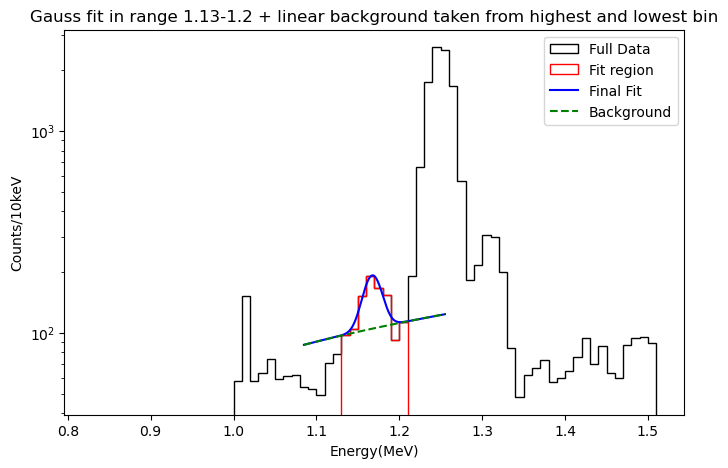

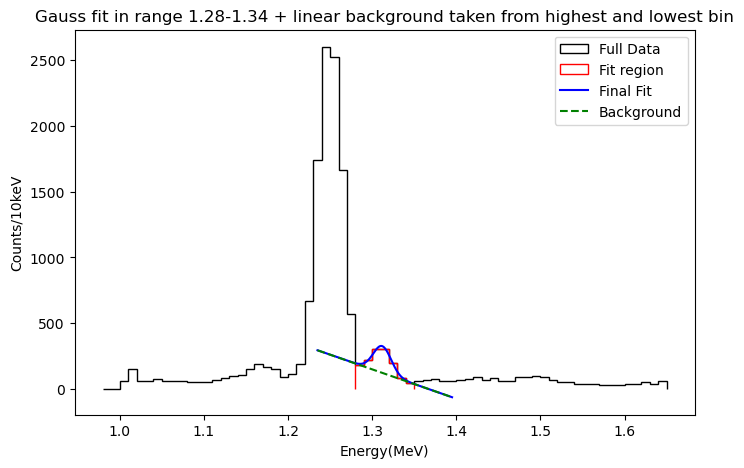

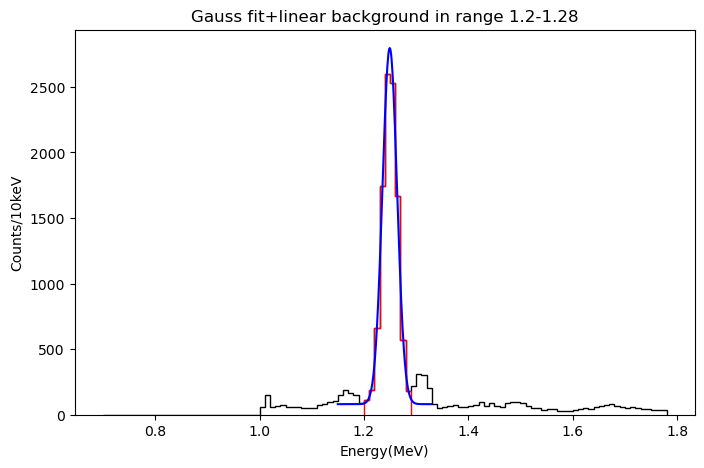

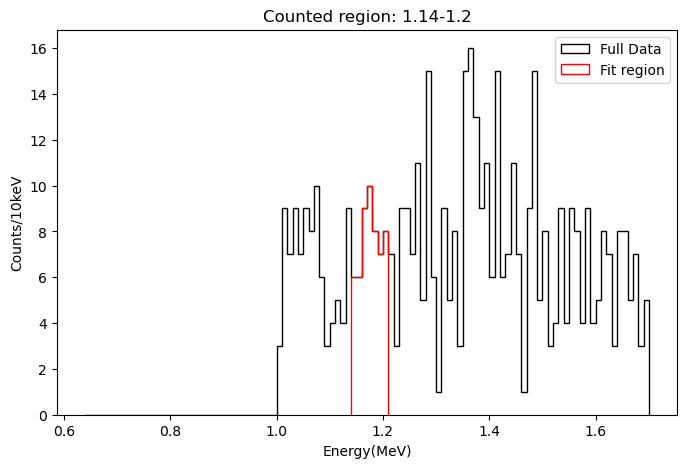

In [157]:
leftsat = fixedlin_fit(E, 1.13,1.20, gamma=2, quiet=False, yscale='log')
rightsat = fixedlin_fit(E, 1.28,1.34, gamma=0, quiet=False, yscale='linear')
main = standard_fit(E, 1.20, 1.28, a_lowerbound=0, gamma=1, quiet=False, yscale='linear')

percent_left = leftsat['peak_counts']/leftsat['total_fitted_counts']
percent_right = rightsat['peak_counts']/rightsat['total_fitted_counts']
percent_right_uncertainty = percent_right * np.sqrt((rightsat['peak_counts_uncertainty'] / rightsat['peak_counts'])**2 + (rightsat['total_fitted_uncertainty'] / rightsat['total_fitted_counts'])**2)
percent_left_uncertainty = percent_left * np.sqrt((leftsat['peak_counts_uncertainty'] / leftsat['peak_counts'])**2 + (leftsat['total_fitted_uncertainty'] / leftsat['total_fitted_counts'])**2)


leftsat_2p, leftsat_2p_err = counter(E2p, 1.14,1.20, quiet=False, yscale='linear')
rightsat_2p, rightsat_2p_err = counter(E2p, 1.29,1.34, quiet=True)
main_2p, main_2p_err = counter(E2p, 1.21,1.28, quiet=True, yscale='linear')

leftsat_counts = leftsat['peak_counts']-percent_left*leftsat_2p
leftsat_counts_err = np.sqrt(leftsat['peak_counts_uncertainty']**2 +(percent_left * leftsat_2p_err)**2 +(leftsat_2p * percent_left_uncertainty)**2)

rightsat_counts = rightsat['peak_counts']-rightsat_2p*percent_right
rightsat_counts_err = np.sqrt(rightsat['peak_counts_uncertainty']**2 +(percent_right * rightsat_2p_err)**2 +(rightsat_2p * percent_right_uncertainty)**2)

main_counts = main['total_fitted_counts']+leftsat['background_counts']+rightsat['background_counts']-main_2p-(1-percent_left*leftsat_2p)-(1-percent_right*rightsat_2p)
main_counts_err = np.sqrt(main['total_fitted_uncertainty']**2+leftsat['background_counts_uncertainty']**2+rightsat['background_counts_uncertainty']**2+
                          +main_2p_err**2+np.sqrt((leftsat_2p * percent_left_uncertainty)**2 + (percent_left * leftsat_2p_err)**2)+np.sqrt((rightsat_2p * percent_right_uncertainty)**2 + (percent_right * rightsat_2p_err)**2))
print(f"Total main peak counts corrected for 2p and satelite backgrounds: {main_counts:.0f} ± {main_counts_err:.0f} counts")
print(f"Total left satelite peak counts corrected for 2p: {leftsat_counts:.0f} ± {leftsat_counts_err:.0f} counts")
print(f"Total right satelite peak counts corrected for 2p: {rightsat_counts:.0f} ± {rightsat_counts_err:.0f} counts")
print()
print("="*100)
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {main['mean']:.3f} ± {main['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {main['truepeak']:.3f} ± {main['truepeak_uncertainty']:.3f}")
print()
print(f"left peak:")
print(f"Proton energies:            {leftsat['mean']:.3f} ± {leftsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {leftsat['truepeak']:.3f} ± {leftsat['truepeak_uncertainty']:.3f}")
print()
print(f"Right peak:")
print(f"Proton energies:            {rightsat['mean']:.3f} ± {rightsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {rightsat['truepeak']:.3f} ± {rightsat['truepeak_uncertainty']:.3f}")
print()

DSSSD error only used
--- Fit Values---
Peak Mean:                     1.850 ± 0.002
22Mg excited level energy:     7.774 ± 0.002
Peak Counts:                   201.61 ± 22.68
Background Counts:             328.55 ± 25.32
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 530.16 ± 33.99

non-twoproton events counts: 188 ± 48
twoproton events counts: 343 ± 34
Fitted means for the peaks and their true value

Main peak:
Proton energies:            1.850 ± 0.002
22Mg excitedstate energies: 7.774 ± 0.002


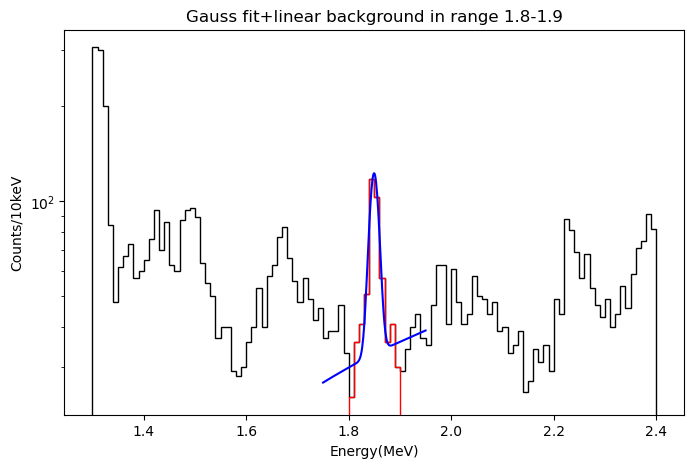

In [178]:
fourth = standard_fit(E, 1.8, 1.9, a_lowerbound=0, gamma=1, quiet=False)
c2p, err = counter(E2p, 1.8,1.9, quiet=True)
c = fourth['total_fitted_counts']-c2p
c_err = np.sqrt(fourth['total_fitted_uncertainty']**2+err**2)
print(f"non-twoproton events counts: {c:.0f} ± {c_err:.0f}")
print(f"twoproton events counts: {c2p:.0f} ± {err:.0f}")
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {fourth['mean']:.3f} ± {fourth['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {fourth['truepeak']:.3f} ± {fourth['truepeak_uncertainty']:.3f}")

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.486 ± 0.002
22Mg excited level energy:     8.441 ± 0.002
Peak Counts:                   2328.04 ± 70.64
Background Counts:             1074.68 ± 61.09
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 3402.72 ± 93.39

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.386 ± 0.003
22Mg excited level energy:     8.337 ± 0.003
Peak Counts:                   70.11 ± 10.15
Background Counts:             462.00 ± 40.21
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 532.11 ± 41.47

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.565 ± 0.003
22Mg excited level energy:     9.908 ± 0.003
Peak Counts:                   115.44 ± 22.13
Background Counts:             355.00 ± 29.79
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 470.44 ± 37.

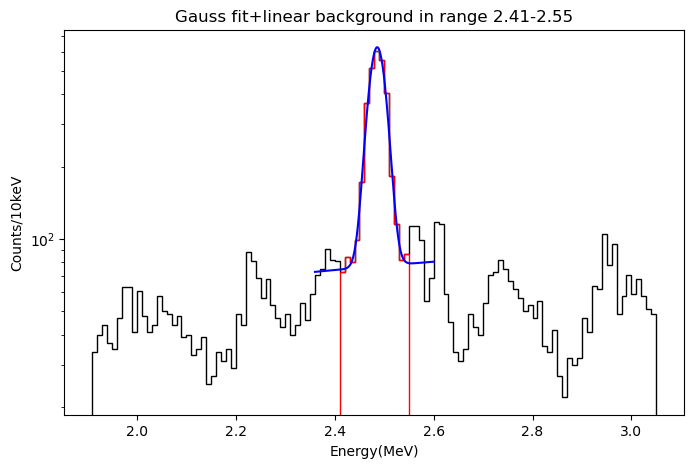

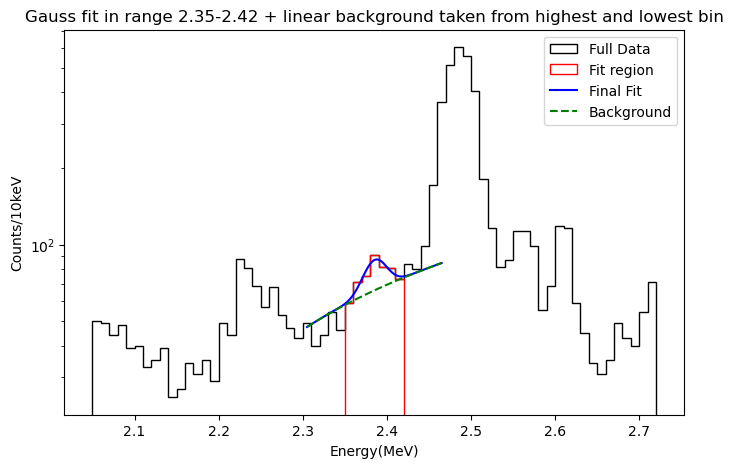

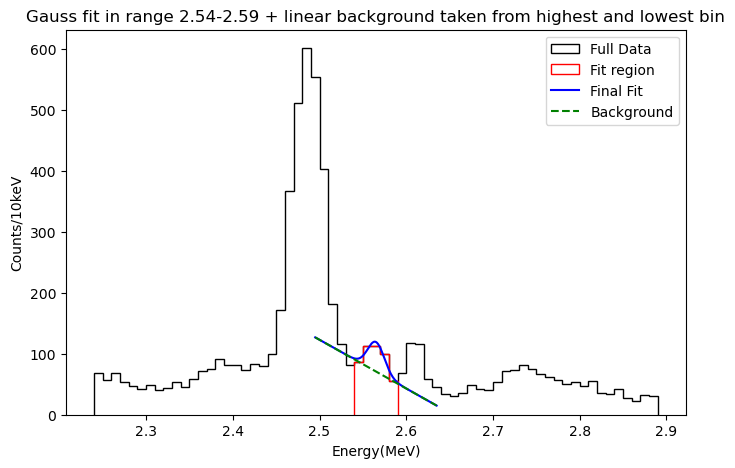

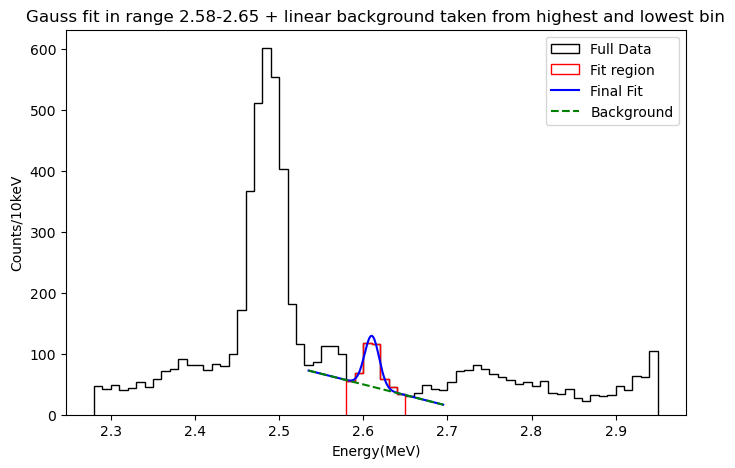

In [179]:
#plt.hist(E/1e3, bins=np.arange(2.3,2.7+bw,bw), histtype='step', color='k')
#plt.xlabel("Energy(MeV)")
#plt.ylabel("Counts/10keV")
#plt.yscale('log')
fifth = standard_fit(E, 2.41,2.55, gamma=1, quiet=False)
c2p, err = counter(E2p, 2.41,2.54, quiet=True)
c = fifth['total_fitted_counts']-c2p
c_err = np.sqrt(fifth['total_fitted_uncertainty']**2+err**2)
#print(f"non-twoproton events counts: {c:.0f} ± {c_err:.0f}")
#print(f"twoproton events counts: {c2p:.0f} ± {err:.0f}")

leftsat = fixedlin_fit(E, 2.35,2.42, gamma=1, quiet=False, yscale='log')

rightsat = fixedlin_fit(E, 2.54,2.59, gamma=2, quiet=False, yscale='linear')
rightsat2 = fixedlin_fit(E, 2.58,2.65, gamma=0, quiet=False, yscale='linear')

percent_left = leftsat['peak_counts']/leftsat['total_fitted_counts']
percent_right = rightsat['peak_counts']/rightsat['total_fitted_counts']
percent_right2 = rightsat2['peak_counts']/rightsat2['total_fitted_counts']

percent_right2_uncertainty = percent_right2 * np.sqrt((rightsat2['peak_counts_uncertainty'] / rightsat2['peak_counts'])**2 + (rightsat2['total_fitted_uncertainty'] / rightsat2['total_fitted_counts'])**2)
percent_right_uncertainty = percent_right * np.sqrt((rightsat['peak_counts_uncertainty'] / rightsat['peak_counts'])**2 + (rightsat['total_fitted_uncertainty'] / rightsat['total_fitted_counts'])**2)
percent_left_uncertainty = percent_left * np.sqrt((leftsat['peak_counts_uncertainty'] / leftsat['peak_counts'])**2 + (leftsat['total_fitted_uncertainty'] / leftsat['total_fitted_counts'])**2)


rightsat_2p, rightsat_2p_err = counter(E2p, 2.54,2.58, quiet=True)
rightsat2_2p, rightsat2_2p_err = counter(E2p, 2.58,2.64, quiet=True)
leftsat_2p, leftsat_2p_err = counter(E2p, 2.34,2.41, quiet=True)

#righto = fixedlin_fit(E2p, 2.58,2.64, quiet=False)


leftsat_counts = leftsat['peak_counts']-leftsat_2p*percent_left
leftsat_counts_err = np.sqrt(leftsat['peak_counts_uncertainty']**2 +(percent_left * leftsat_2p_err)**2 +(leftsat_2p * percent_left_uncertainty)**2)
rightsat_counts = rightsat['peak_counts']-rightsat_2p*percent_right
rightsat_counts_err = np.sqrt(rightsat['peak_counts_uncertainty']**2+(percent_right * rightsat_2p_err)**2 +(rightsat_2p * percent_right_uncertainty)**2)
rightsat2_counts = rightsat2['peak_counts']-rightsat2_2p*percent_right2
rightsat2_counts_err = np.sqrt(rightsat2['peak_counts_uncertainty']**2+(percent_right2 * rightsat2_2p_err)**2 +(rightsat2_2p * percent_right2_uncertainty)**2)

main_counts = main['total_fitted_counts']+leftsat['background_counts']+rightsat['background_counts']-main_2p-(1-percent_left*leftsat_2p)-(1-percent_right*rightsat_2p)-(1-percent_right2*rightsat2_2p)
main_counts_err = np.sqrt(main['total_fitted_uncertainty']**2+leftsat['background_counts_uncertainty']**2+rightsat['background_counts_uncertainty']**2+
                          +main_2p_err**2+np.sqrt((leftsat_2p * percent_left_uncertainty)**2 + 
                            (percent_left * leftsat_2p_err)**2)+np.sqrt((rightsat_2p * percent_right_uncertainty)**2 + (percent_right * rightsat_2p_err)**2)
                          +np.sqrt((rightsat2_2p * percent_right2_uncertainty)**2 + (percent_right2 * rightsat2_2p_err)**2))

print(f"Total main peak counts corrected for 2p and satelite backgrounds: {(main_counts+rightsat2_counts+leftsat_counts):.0f} ± {np.sqrt(main_counts_err**2+rightsat2_counts_err**2+leftsat_counts_err**2):.0f} counts")
print(f"Total right satelite peak counts corrected for 2p: {rightsat_counts:.0f} ± {rightsat_counts_err:.0f} counts")
print(f"Total right2 satelite peak counts corrected for 2p: {rightsat2_counts:.0f} ± {rightsat2_counts_err:.0f} counts")
print(f"Total left satelite peak counts corrected for 2p: {leftsat_counts:.0f} ± {leftsat_counts_err:.0f} counts")


print(f"The right2 & left peak has been subtracted from the main peak as there seems to a contribution from 2p events from the background")
print()
print("="*100)
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {fifth['mean']:.3f} ± {fifth['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {fifth['truepeak']:.3f} ± {fifth['truepeak_uncertainty']:.3f}")
print()
print(f"left peak:")
print(f"Proton energies:            {leftsat['mean']:.3f} ± {leftsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {leftsat['truepeak']:.3f} ± {leftsat['truepeak_uncertainty']:.3f}")
print()
print(f"Right peak:")
print(f"Proton energies:            {rightsat['mean']:.3f} ± {rightsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {rightsat['truepeak']:.3f} ± {rightsat['truepeak_uncertainty']:.3f}")
print()
print(f"Right2 peak:")
print(f"Proton energies:            {rightsat2['mean']:.3f} ± {rightsat2['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {rightsat2['truepeak']:.3f} ± {rightsat2['truepeak_uncertainty']:.3f}")
print()

DSSSD error only used
--- Fit Values---
Peak Mean:                     5.456 ± 0.002
22Mg excited level energy:     14.051 ± 0.003
Peak Counts:                   149.08 ± 9.21
Background Counts:             93.50 ± 22.68
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 242.58 ± 24.48

DSSSD error only used
--- Fit Values---
Peak Mean:                     3.881 ± 0.003
22Mg excited level energy:     9.903 ± 0.004
Peak Counts:                   202.86 ± 27.18
Background Counts:             180.00 ± 26.83
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 382.86 ± 38.20


Peak in range 3.84-3.92:
Total counts sub 2p 366.23 ± 38.91



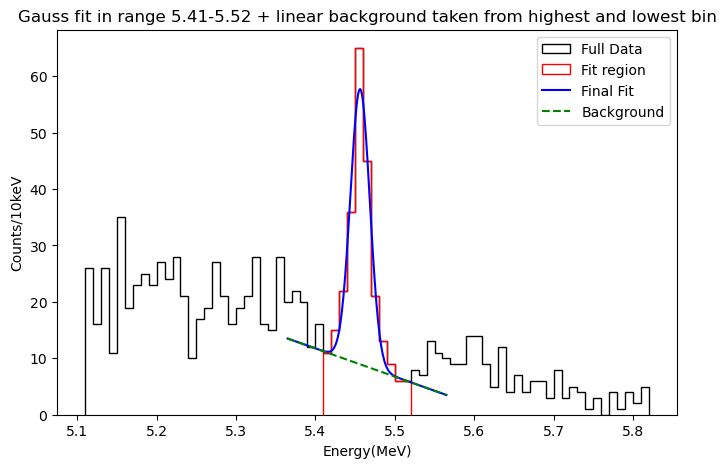

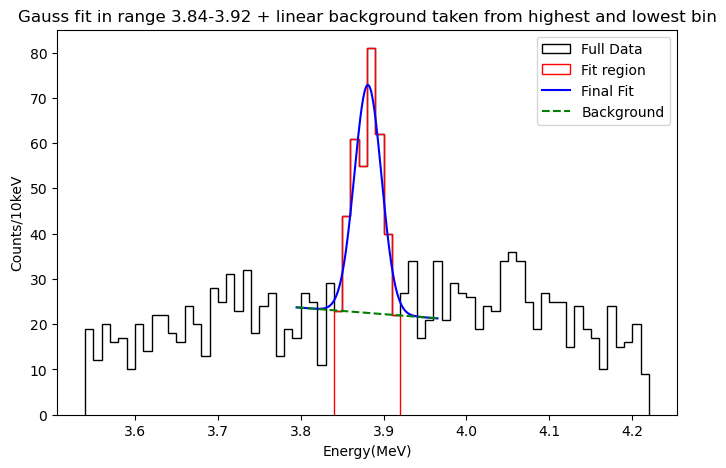

In [177]:
main = fixedlin_fit(E, 5.41, 5.52, gamma=3, quiet=False, yscale='linear')
main2 = fixedlin_fit(E, 3.84,3.92, gamma=1, yscale='linear')#, a_lowerbound=0)
main2_c, main2_c_err = counter(E2p, 3.84,3.92, yscale='linear', quiet=True)#, a_lowerbound=0)
main_counts = main2['total_fitted_counts']-main2_c
main_counts_err = np.sqrt(main2['total_fitted_uncertainty']**2+main2_c_err**2)
print("="*100)
print()
print(f"Peak in range 3.84-3.92:")
print(f"Total counts sub 2p {main_counts:.2f} ± {main_counts_err:.2f}")

print()

pad error used
--- Fit Values---
Peak Mean:                     6.523 ± 0.005
22Mg excited level energy:     14.056 ± 0.006
Peak Counts:                   37.85 ± 6.18
Background Counts:             48.00 ± 13.86
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 85.85 ± 15.17

pad error used
--- Fit Values---
Peak Mean:                     7.847 ± 0.006
22Mg excited level energy:     14.060 ± 0.006
Peak Counts:                   47.00 ± 7.27
Background Counts:             16.50 ± 9.53
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 63.50 ± 11.98



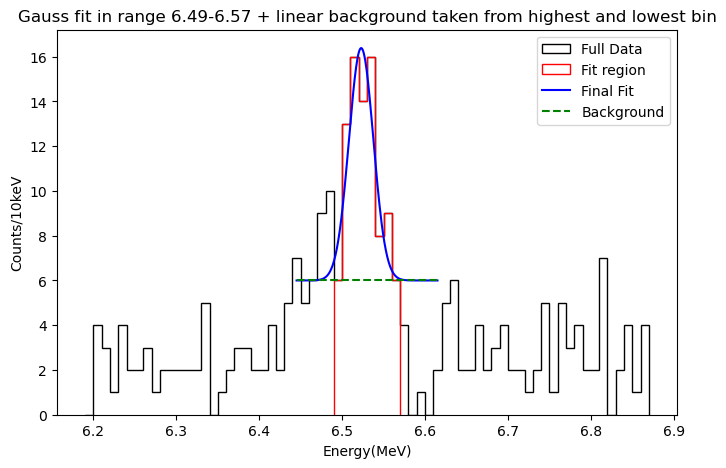

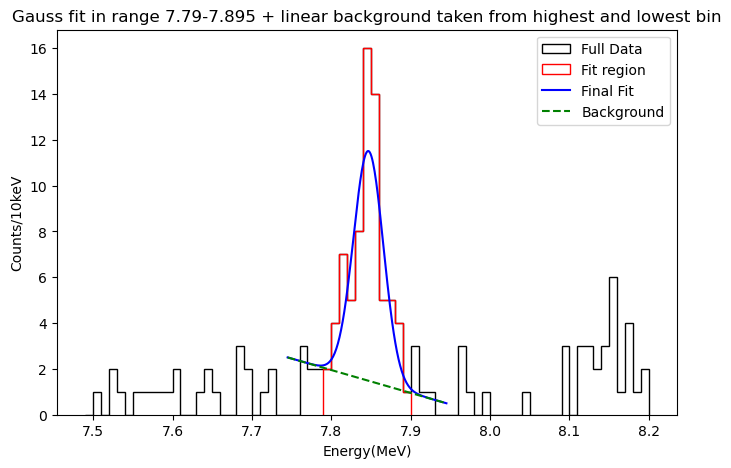

In [146]:
# overlapping satellite peak -> not usable for gaussian determination!

main = fixedlin_fit(E, 6.49, 6.57, gamma=2, quiet=False, yscale='linear', deps=(fEdep,bEdep))

main = fixedlin_fit(E, 7.79, 7.895, gamma=1, quiet=False, yscale='linear', deps=(fEdep,bEdep))


In [147]:
################# from inside beta region

data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
Alb_files = glob.glob(os.path.join(data_path+"/exclbetacut/", "*mlio.root"))

Eb = np.array([]); fEdepb = np.array([]); bEdepb=np.array([])
for batch in uproot.iterate(Alb_files, expressions=["E", "fEdep", "bEdep"],
                            cut="(id==3)"):
    Eb=np.append(E, ak.flatten(batch.E))
    fEdepb=np.append(fEdep, ak.flatten(batch.fEdep))
    bEdepb=np.append(bEdep, ak.flatten(batch.bEdep))
    

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_29164/1757427454.py:66: RuntimeWarning: invalid value encountered in double_scalars
  relative_variance = (uncertainty_N / N)**2 + \


DSSSD error only used
--- Fit Values---
Peak Mean:                     1.015 ± inf
22Mg excited level energy:     6.900 ± inf
Peak Counts:                   35.57 ± nan
Background Counts:             199.50 ± 17.30
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 235.07 ± nan

DSSSD error only used
--- Fit Values---
Peak Mean:                     0.691 ± 0.002
22Mg excited level energy:     6.228 ± 0.002
Peak Counts:                   124.85 ± 10.51
Background Counts:             45.00 ± 11.62
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 169.85 ± 15.67

DSSSD error only used
--- Fit Values---
Peak Mean:                     0.450 ± 0.003
22Mg excited level energy:     6.308 ± 0.003
Peak Counts:                   101.23 ± 16.01
Background Counts:             178.50 ± 24.99
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 279.73 ± 29.68



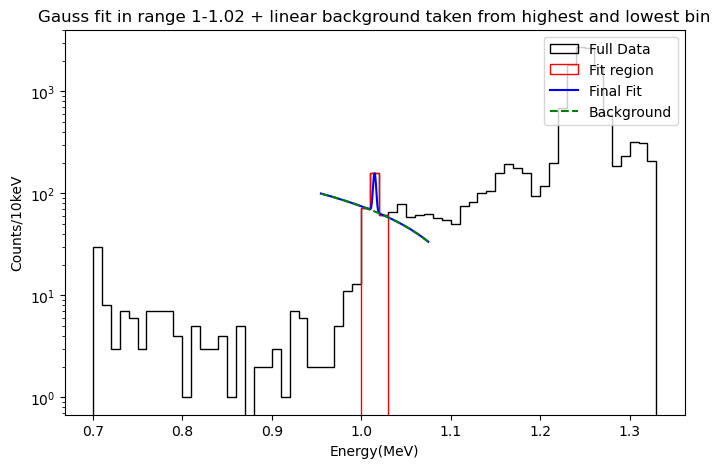

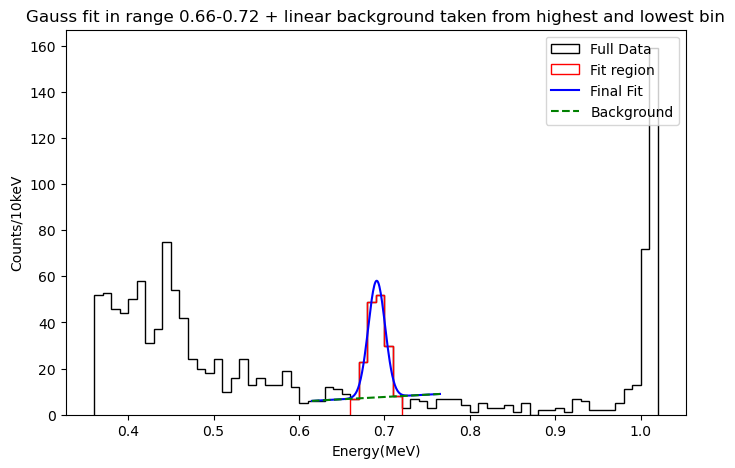

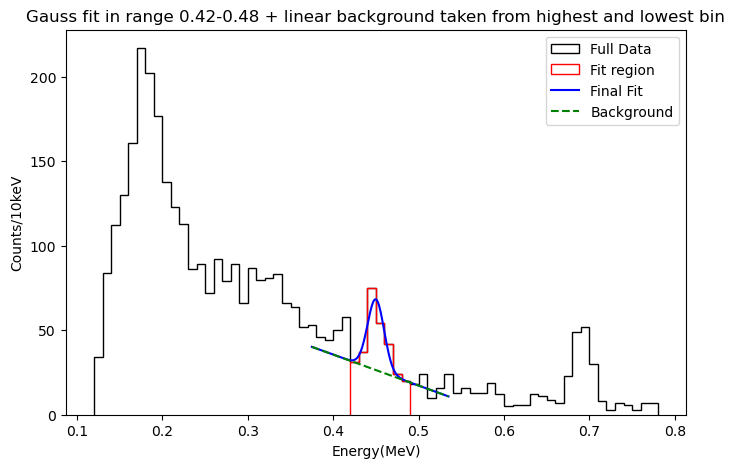

In [148]:
main = fixedlin_fit(Eb, 1, 1.02, gamma=1, quiet=False, yscale='log')
#main2 = fixedlin_fit(Eb, 0.73, 0.80, gamma=0, quiet=False, yscale='linear')
main3 = fixedlin_fit(Eb, 0.66, 0.72, gamma=0, quiet=False, yscale='linear')
main4 = fixedlin_fit(Eb, 0.42, 0.48, gamma=1, quiet=False, yscale='linear')